Demonstration of grid search to compare classifier performance
============================================================================
An important step in classifier performance comparison is hyperparameter 
optimization. Here, we specify the classifer models we want to tune and a 
dictionary of hyperparameter ranges (preferably similar for fairness in 
comparision) for each classifier. Then, we find the optimal hyperparameters 
through a function that uses GridSearchCV and refit the optimized 
models to obtain accuracies. 

In this example, we tune hyperparameters for two classifiers, Random Forest and Extra Trees, and compare their performance on an OpenML-CC18 benchmarking suite dataset (https://www.openml.org/d/15).  We can see clearly in the resulting plot that the optimized models perform better than or atleast similar to the default parameter models. On the dataset we use in this example, RF performs marginally better than ExtraTrees overall.


In [2]:
print(__doc__)

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

Automatically created module for IPython interactive environment


In [28]:
def hyperparameter_optimization_grid(X, y, *argv):
    """
    Given a classifier and a dictionary of hyperparameters, 
    find optimal hyperparameters using GridSearchCV.

    Parameters
    ----------
    X : numpy.ndarray
        Input data, shape (n_samples, n_features)
    y : numpy.ndarray
        Output data, shape (n_samples, n_outputs)
    *argv : list of tuples (classifier, hyperparameters)
        List of (classifier, hyperparameters) tuples:

        classifier : sklearn-compliant classifier
            For example sklearn.ensemble.RandomForestRegressor, 
            rerf.rerfClassifier, etc
        hyperparameters : dictionary of hyperparameter ranges
            See https://scikit-learn.org/stable/modules/generated
                /sklearn.model_selection.GridSearchCV.html. 

    Returns
    -------
    clf_best_params : dictionary
        Dictionary of best hyperparameters
    """
    
    clf_best_params = {}

    kappa_scorer = make_scorer(cohen_kappa_score)

    # Iterate over all (classifier, hyperparameters) pairs
    for clf, params in argv:

        # Run grid search
        grid_search = GridSearchCV(
            clf, param_grid=params, scoring=kappa_scorer, cv=10, iid=False
        )
        grid_search.fit(X, y)

        # Save results
        clf_best_params[clf] = grid_search.best_params_

        # Generate heatmaps 
        param_heatmap(grid_search, params, str(clf))

        
    return clf_best_params

In [31]:
def param_heatmap(search_object, params, clf_name):
    """
    Given an sklearn parameter search object, dictionary of 
    two parameter ranges, and classifier name, 
    generate heatmap showing model scores for each 
    pair of parameter values.

    Parameters
    ----------
    search_object : sklearn parameter search object
        For example sklearn.model_selection.GridSearchCV
    params : dictionary of hyperparameter ranges
        See https://scikit-learn.org/stable/modules/generated
            /sklearn.model_selection.GridSearchCV.html.
    clf_name : string
        Name of sklearn-compliant classifier
    """
    
    pair_arrays = []
    for i in range(len(params)-1):
        for j in range(len(params)-1):
            param1_name = list(params.keys())[i]
            param2_name = list(params.keys())[j+1]
            param1 = params[param1_name]
            param2 = params[param2_name]
            scores = search_object.cv_results_['mean_test_score'].reshape(
                len(param1), len(param2))
            pair_arrays.append(scores)
                
            a = -np.array(scores)
            a = a.ravel().argsort().argsort().reshape(a.shape)
                
            plt.figure(figsize=(8, 6))
            plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
            plt.imshow(a, interpolation='nearest', cmap=plt.cm.hot)
            plt.xlabel(param2_name)
            plt.ylabel(param1_name)
            plt.colorbar()
            plt.xticks(np.arange(len(param2)), param2)
            plt.yticks(np.arange(len(param1)), param1)
            plt.title('Grid Search Kappa Rank ' + clf_name)
            plt.show()

# Building classifiers and specifying parameter ranges to sample from


In [23]:
# get some data
X, y = fetch_openml(data_id=15, return_X_y=True, as_frame=True) #breast-w dataset: 15
y = pd.factorize(y)[0]
X = X.apply(lambda x: pd.factorize(x)[0])
n_samples, n_features = np.shape(X)

# build a classifier
extraTrees = ExtraTreesClassifier(warm_start=True)

# specify parameters and distributions to sample from
extraTrees_param_dict = {
    "max_features": ["sqrt", "log2", None],
    "n_estimators": [50,100,150,200],
}

# build another classifier
rf = RandomForestClassifier(warm_start=True)

# specify parameters and distributions to sample from
rf_param_dict = {
    "max_features": ["sqrt", "log2", None],
    "n_estimators": [50,100,150,200],
}

# Obtaining best parameters dictionary and refitting

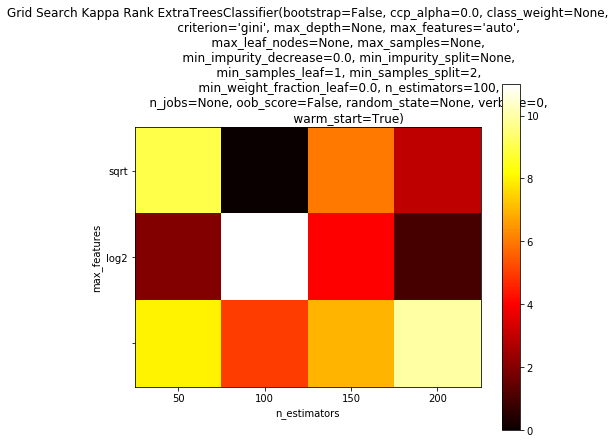

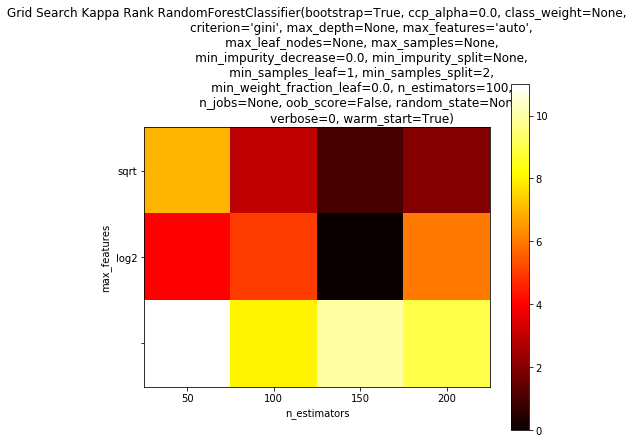

{ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=True): {'max_features': 'sqrt', 'n_estimators': 100}, RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10

In [32]:
best_params = hyperparameter_optimization_grid(
    X, y, (extraTrees, extraTrees_param_dict), (rf, rf_param_dict)
)

print(best_params)

# extract values from dict - seperate each classifier's param dict
keys, values = zip(*best_params.items())

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [16]:
def get_accuracy(model, X_train, y_train, X_test, y_test):
    """
    Given a model, train, and test data, 
    fit model and calculate accuracy of predictions.

    Parameters
    ----------
    model : sklearn-compliant classifier
    X_train : numpy.ndarray
        Train input data, shape (n_samples, n_features)
    y_train  numpy.ndarray
        Train output data, shape (n_samples, n_outputs)
    X_test: numpy.ndarray
        Test input data, shape (n_samples, n_features)
    y_test:numpy.ndarray
        Test output data, shape (n_samples, n_outputs)

    Returns
    -------
    accuracy : float
        An sklearn metric for model performance.
    """
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    return accuracy

# get accuracies of optimized and default models
extraTrees_models = [ExtraTreesClassifier(**values[0]), ExtraTreesClassifier()]
extraTrees_acc = []
for model in extraTrees_models:
    extraTrees_acc.append(get_accuracy(
        model, X_train, y_train, X_test, y_test))

rf_models = [RandomForestClassifier(**values[1]), RandomForestClassifier()]
rf_acc = []
for model in rf_models:
    rf_acc.append(get_accuracy(
        model, X_train, y_train, X_test, y_test))


# Plotting the result

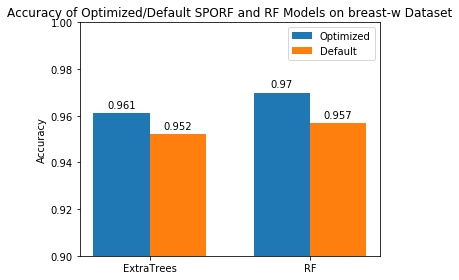

In [17]:
labels = ["ExtraTrees", "RF"]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, extraTrees_acc, width, label="Optimized")
rects2 = ax.bar(x + width / 2, rf_acc, width, label="Default")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Accuracy")
ax.set_title(
    "Accuracy of Optimized/Default SPORF and RF Models on breast-w Dataset")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = float("%.3f" % (rect.get_height()))
        ax.annotate(
            "{}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.ylim((0.9, 1))

plt.show()